In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
img = cv2.imread('../data/document.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = np.float32(gray)/255

(<Axes: >, <matplotlib.image.AxesImage at 0x1e592f17950>)

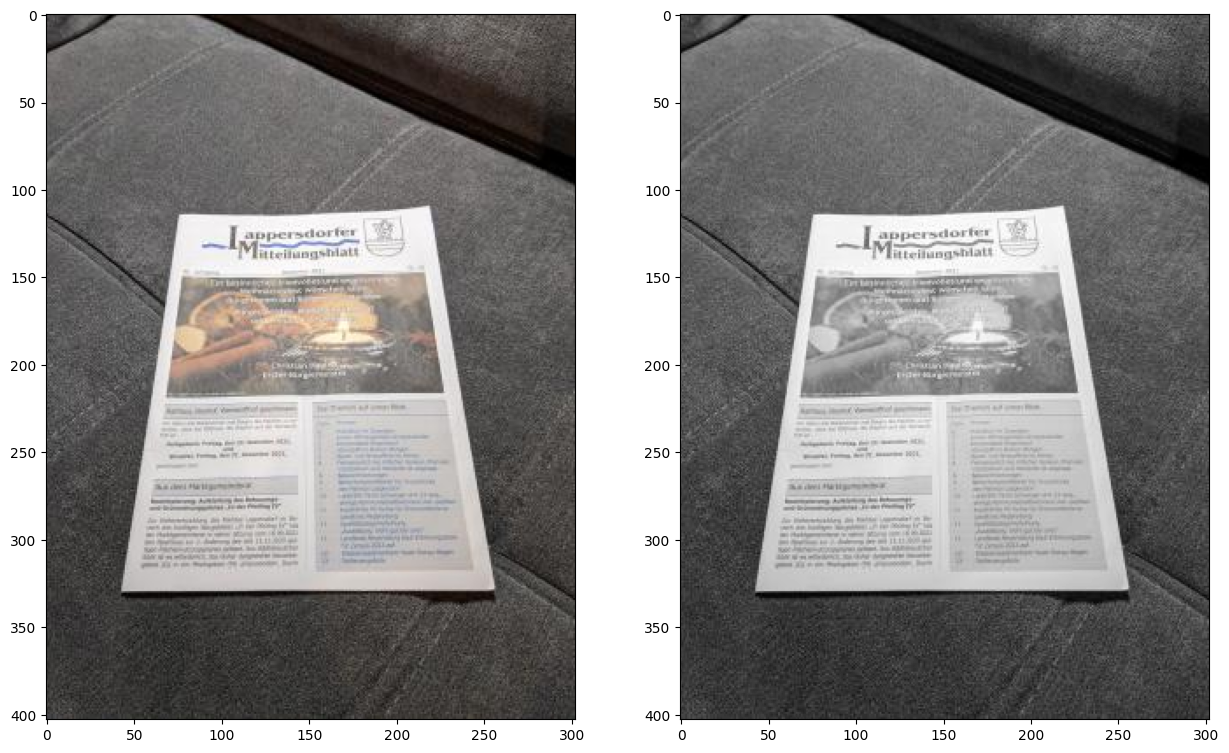

In [4]:
rows, cols = gray.shape

# Let's plot the images (colour and gray scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

(<Axes: >, <matplotlib.image.AxesImage at 0x1e593047830>)

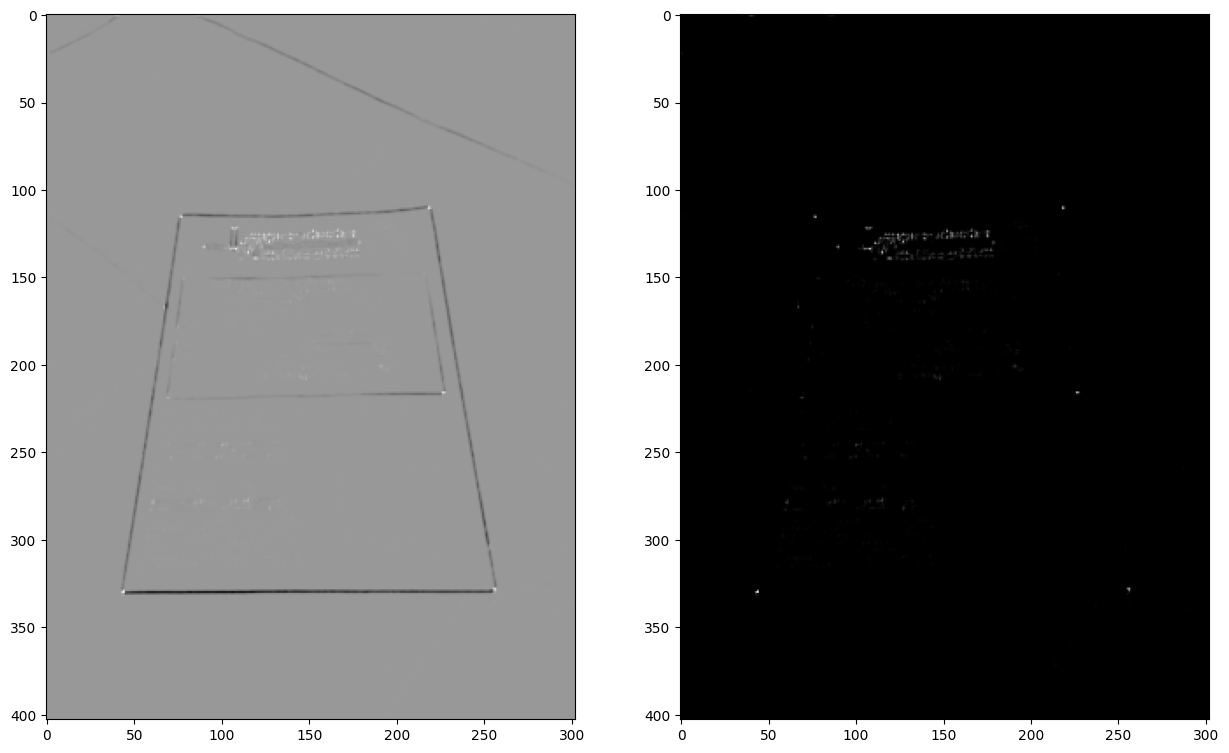

In [5]:
#Harris Corner Detector
#детектор Харриса вычисляет оценку "угловатости" для каждого пикселя изображения.
cornerness = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
'''"Угловатость" (cornerness) R вычисляется по формуле: R = det(M) - k * (trace(M))^2
где det(M) - определитель матрицы M, trace(M) - след матрицы M, k - эмпирический коэффициент (обычно 0.04-0.06).
Интерпретация значений R:
Большие положительные значения R указывают на вероятные углы.
Значения R близкие к нулю указывают на плоские области.
Отрицательные значения R чаще всего соответствуют краям.'''
cornerness_harris = cornerness.copy() 
cornerness[cornerness < 0] = 0
plt.subplot(121), plt.imshow(cornerness_harris , cmap='gray')
plt.subplot(122), plt.imshow(cornerness , cmap='gray')

(np.float64(-0.5), np.float64(301.5), np.float64(402.5), np.float64(-0.5))

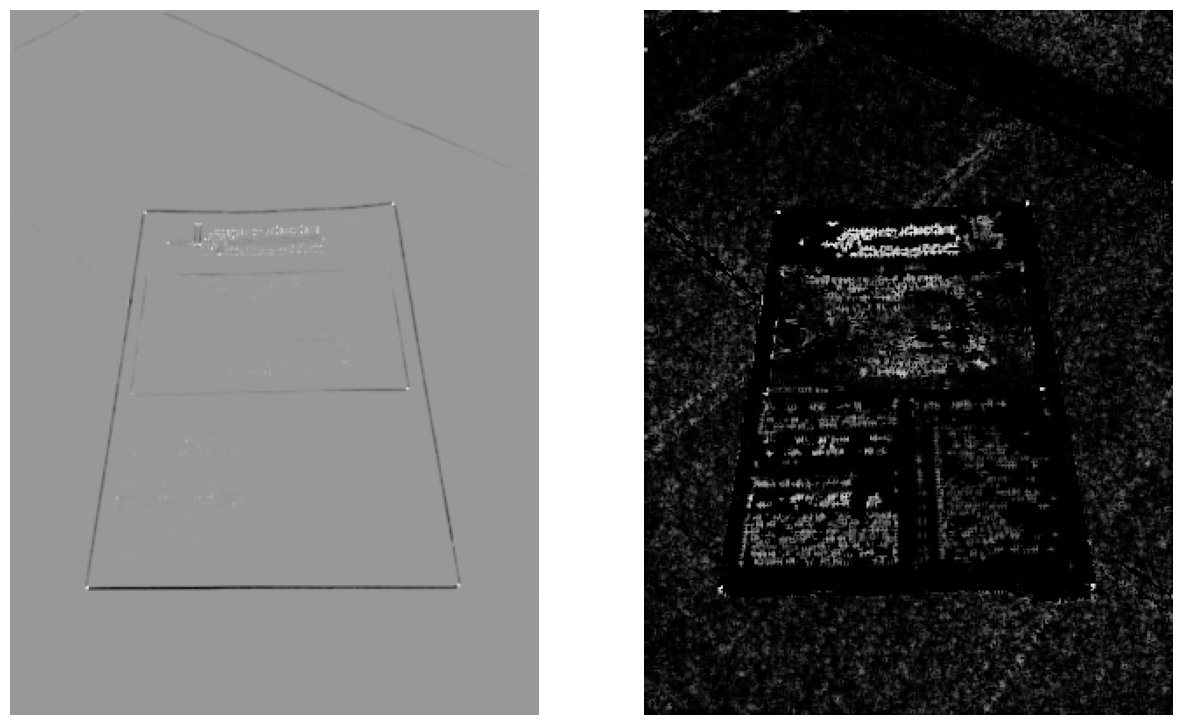

In [6]:
# Since cornerness has a huge dynamic range, let's take the logarithm for better visualization and manipulation
cornerness = np.log(cornerness + 1e-6)

plt.subplot(121), plt.imshow(cornerness_harris , cmap='gray') 
plt.axis(False)
plt.subplot(122), plt.imshow(cornerness , cmap='gray') 
plt.axis(False)

(np.float64(-0.5), np.float64(301.5), np.float64(402.5), np.float64(-0.5))

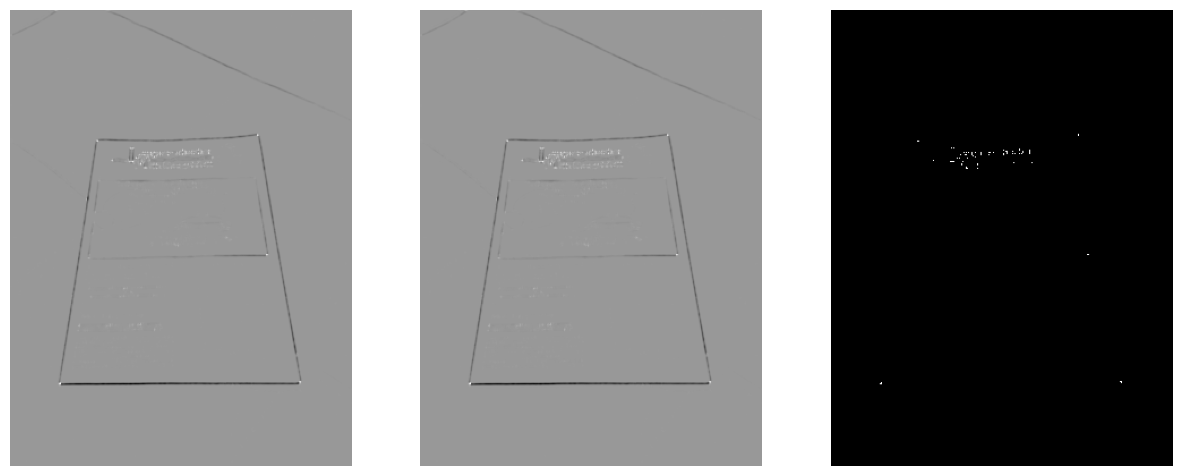

In [7]:
#эксперементы
cornerness_normalized = cv2.normalize(cornerness_harris, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
# Пороговая обработка для выделения углов
threshold = 180
corners_n = np.zeros(gray.shape, dtype=np.uint8)
corners_n[cornerness_normalized > threshold] = 255
plt.subplot(131), plt.imshow(cornerness_harris, cmap='gray') 
plt.axis(False)
plt.subplot(132), plt.imshow(cornerness_normalized, cmap='gray') 
plt.axis(False)
plt.subplot(133), plt.imshow(corners_n, cmap='gray') 
plt.axis(False)

Как мы можем отфильтровать все, кроме 4 углов документа?
Для этой цели давайте разработаем пользовательский дескриптор особенностей, 
подходящий для обнаружения углов документа. 
Чтобы сделать это, давайте посмотрим на верхний левый угол.
Хорошим дескриптором для этого угла, учитывая определенную окрестность, 
было бы определение того, что нижний правый квадрант (намного) ярче, 
чем три других квадранта (т.е. верхний левый, верхний правый, нижний левый). 
Давайте реализуем это

(<Axes: >, <matplotlib.image.AxesImage at 0x1e592f160c0>)

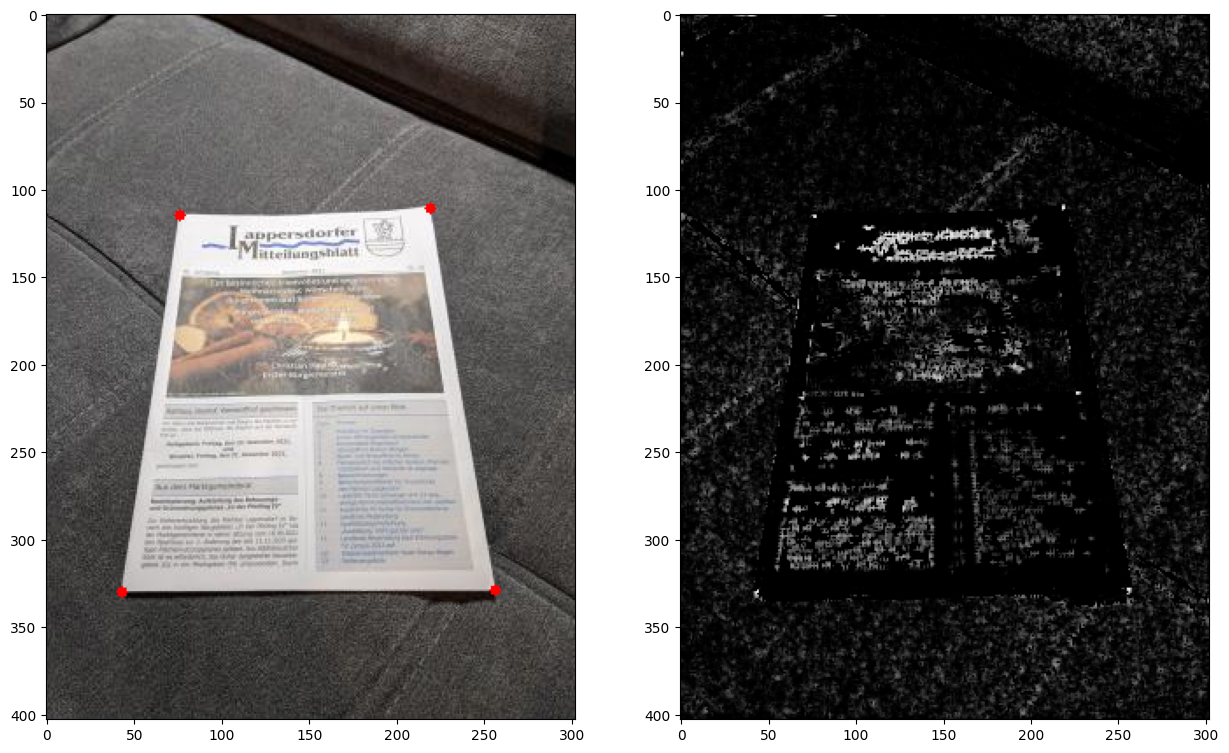

In [9]:
# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_ritgh = None, None

# Size of each quadrant (in pixels)
quad_size = 7

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        if cornerness[r, c] < -7:
            continue
        
        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]
        
        # Extract the four quandrants
        quad_top_left = block[0:quad_size, 0:quad_size]
        quad_top_right = block[0:quad_size, quad_size+1:]
        quad_bottom_left = block[quad_size+1:, 0:quad_size]
        quad_bottom_right = block[quad_size+1:, quad_size+1:]
        
        # Top-left corner
        # For the top-left document corner, the bottom-right quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants
        descriptor = np.mean(quad_bottom_right) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_top_left:
            # We update the threshold
            th_top_left = descriptor
            # And we update the optimal location
            opt_top_left = (c, r)
            
        # Top-right corner
        descriptor = np.mean(quad_bottom_left) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_right)
        if descriptor > th_top_right:
            th_top_right = descriptor
            opt_top_right = (c, r)
        
        # Bottom-left corner
        descriptor = np.mean(quad_top_right) - \
                     np.mean(quad_top_left) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
        if descriptor > th_bottom_left:
            th_bottom_left = descriptor
            opt_bottom_left = (c, r)
        
        # Bottom-right corner
        descriptor = np.mean(quad_top_left) - \
                     np.mean(quad_top_right) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
        if descriptor > th_bottom_right:
            th_bottom_right = descriptor
            opt_bottom_right = (c, r)

# Let's draw circles at the detected corners
out = cv2.circle(img, opt_top_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_top_right, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_right, 3, (255,0,0), -1)

# And finally we plot the images (with the detected document corners)
plt.subplot(121), plt.imshow(out)
plt.subplot(122), plt.imshow(cornerness, cmap='gray')

    If we increased the resolution of the camera, 
    what would you change in the current algorithm?

        Если мы используем камеру с более высоким разрешением, 
        общий размер изображения увеличится, но размер квадрантов останется 7x7 пикселей. 
        В результате, эти квадранты будут охватывать меньшую часть реального документа на изображении.
        
        Можно изменять размер квадрантов пропорционально размеру изображения.
        quad_size = max(7, int(min(rows, cols) * 0.01))